In [1]:
import pandas as pd

# loading data

In [2]:
login_df = pd.read_json('logins.json')
ultimate_df = pd.read_json('ultimate_data_challenge.json')

# analysing data

In [3]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Part 1: Exploratory Data Analysis (EDA)

### Aggregating by 15-Minute Intervals:

**login_time column is alreday in datetime format, now setting it as the index.
Resampling the data in 15-minute intervals and counting the number of logins in each interval.**

In [6]:
login_df.set_index('login_time', inplace=True)  # setting index

# Resampling the data by 15-minute intervals and counting logins

login_counts = login_df.resample('15T').size()


In [7]:
login_counts

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Length: 9788, dtype: int64

### Visualize the Time Series:

**Ploting the time series data to identify patterns like peaks and cycles, by Using a line plot to display login counts over time.**

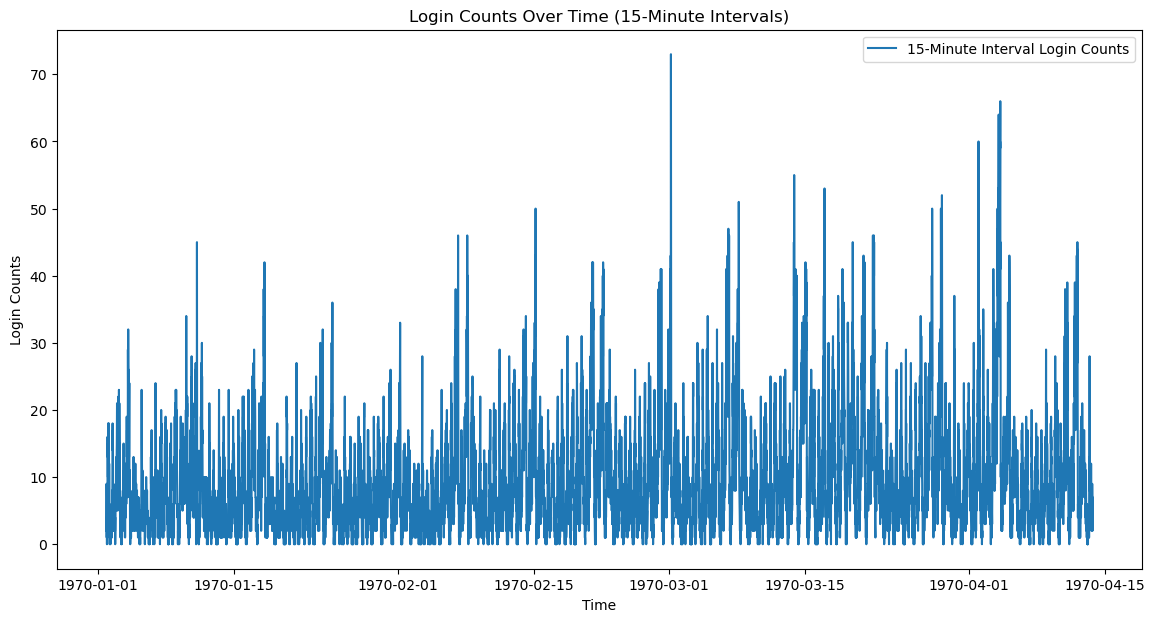

In [8]:
import matplotlib.pyplot as plt       # visual library

# Plotting the time series of login counts
plt.figure(figsize=(14, 7))
plt.plot(login_counts, label='15-Minute Interval Login Counts')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Login Counts Over Time (15-Minute Intervals)')
plt.legend()
plt.show()


## Identify Patterns:


1. **Daily Cycles**: There’s a noticeable pattern of recurring peaks throughout the day, suggesting higher login activity at specific times, likely morning and evening. These peaks hint at daily cycles where users tend to log in during specific parts of the day.

2. **Data Quality Issues**: There don’t appear to be major gaps or missing data points, as the time series looks continuous without abrupt drops to zero, which suggests reliable data collection.

3. **Observations**: The login counts show a repeating pattern, with some days having significantly higher peaks than others. These peaks could be tied to certain days of the week or specific events causing spikes in user activity. The consistent pattern in the peaks supports a daily cycle trend in user logins.


# Part 2: Experiment and Metrics Design

**Scenario:** Two cities, Gotham (active at night) and Metropolis (active during the day), have driver exclusivity due to tolls. The experiment proposes reimbursing toll costs to encourage drivers to work in both cities.


### Key Measure of Success:

**Metric:** The number of drivers serving both cities before and after the toll reimbursement.
Rationale: This metric directly measures the primary objective, encouraging drivers to operate in both cities.


### Experiment Design:

#### a) Implementation:

**Phase 1:** Track driver activity in both cities for a set period without reimbursement.

**Phase 2:** Introduce toll reimbursement and monitor driver activity again. Track the number of unique drivers serving both cities in each phase.

#### b) Statistical Test:

By using a Chi-Square test for proportions to check if the number of drivers serving both cities significantly increased after the reimbursement. Alternatively, by using a paired t-test if the data on driver counts is continuous and can be paired by day or week.

#### c) Interpretation:

If the test shows a significant increase in dual-city service, recommend continuing the reimbursement policy.
If no significant increase is observed, consider alternative incentives.

**Caveats:** Seasonal factors or unusual traffic events may impact results, ensure a sufficient data collection period to minimize these effects.

# Part 3: Predictive Modeling

### Question 1: Data Cleaning and Exploratory Analysis

In [9]:
## Converting signup_date and last_trip_date to datetime format for easier manipulation.

ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])


In [10]:
# determining the last date in the dataset
last_date = ultimate_df['last_trip_date'].max()

# now defining retention as users active within the last 30 days of the dataset
ultimate_df['retained'] = (ultimate_df['last_trip_date'] >= last_date - pd.Timedelta(days=30)).astype(int)


#### Fraction of Retained Users: Calculating the retention rate.

In [11]:
retention_rate = ultimate_df['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")

Retention rate: 37.61%


### Question 2: Build a Predictive Model

In [12]:
## Feature Selection and Handling Missing Values

# Fill missing values with mean model
ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].mean(), inplace=True)
ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].mean(), inplace=True)

# Droping irrelevant columns for prediction
features_df = ultimate_df.drop(columns=['signup_date', 'last_trip_date', 'retained'])

In [13]:
## Converting Categorical Columns: Converting city and phone column into dummy variables for the model.

# One-hot encode categorical variables
features_df = pd.get_dummies(features_df, columns=['city', 'phone'], drop_first=True)

In [14]:
## Train-Test Split: Spliting the data into training and testing sets, with retained as the target variable.

from sklearn.model_selection import train_test_split

X = features_df
y = ultimate_df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)


In [15]:
## Model Training: Using a Random Forest Classifier for prediction due to its interpretability and robustness.


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],       # Number of trees 
    'max_depth': [5, 10, 15],                # Maximum depth 
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
}

# Creating a model object
model = RandomForestClassifier(random_state=14)

# Using GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

# Setting the best parameters to the model
best_model = grid_search.best_estimator_

# Training and evaluating the model with optimized parameters
y_pred = best_model.predict(X_test)
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Optimized Model Accuracy: 0.768
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      6182
           1       0.77      0.56      0.65      3818

    accuracy                           0.77     10000
   macro avg       0.77      0.73      0.74     10000
weighted avg       0.77      0.77      0.76     10000



## Model Choice:

I have chosen **Random Forest Classifier** as the predictive model for this problem due to its interpretability, robustness, and ability to handle both categorical and numerical features effectively. Random Forests are well-suited for this kind of classification problem as they reduce the risk of overfitting and provide feature importance metrics, which can help us understand which factors are most influential in predicting user activity.

## Hyperparameter Tuning:

I have tuned my model using **GridSearchCV** with a set of parameters, including n_estimators (number of trees), max_depth (maximum depth of each tree), and min_samples_split (minimum samples required to split a node). GridSearchCV performed cross-validation to find the optimal combination of parameters that maximized precision. This approach ensures that the model is tuned to balance precision and recall, helping it generalize well on unseen data.

## Model Performance:

The accuracy of the optimized model on the test set was 76.8%, indicating that the model correctly predicted user activity status about 77% of the time.

## Key indicators of performance:

**Precision:** 0.77 for both classes, showing that the model is fairly consistent in its ability to accurately identify active and inactive users.

**Recall:** 0.89 for class 0 (inactive users) but only 0.56 for class 1 (active users). This suggests the model is better at identifying inactive users than active ones, potentially due to class imbalance or feature patterns.

**F1-Score:** 0.83 for inactive users and 0.65 for active users, indicating that the model is more confident in its inactive predictions.

## Alternatives Considered:

Other models like **Logistic Regression** and **Gradient Boosting** were potential alternatives. Logistic Regression is simpler and interpretable but may lack the complexity needed for nuanced patterns in the data. **Gradient Boosting** might have performed well but at the cost of longer training times. **Random Forest** was chosen for its balance of interpretability, robustness, and efficiency.

## Model Validity and Concerns:

The model’s validity is supported by its strong performance on accuracy and precision, but its recall for predicting active users (class 1) could be improved. This suggests it may have a bias toward inactive users. Class imbalance could be affecting this recall, so techniques like SMOTE (Synthetic Minority Over-sampling Technique) or adjusting class weights could further improve recall for active users. Another concern is overfitting, though Random Forest’s ensemble nature helps mitigate this risk.



### Question 3: Leveraging Model Insights for Retention

Ultimate can leverage the insights from this model to improve long-term rider retention in several ways:

**Targeted Engagement:** Since the model provides insights on which users are likely to be inactive in their sixth month, Ultimate could proactively engage these users with personalized incentives, discounts, or reminders to encourage continued activity.

**Optimized Marketing Efforts:** Ultimate could allocate marketing resources more effectively by focusing on users predicted to become inactive, using campaigns designed to retain them.

**Enhanced Service Customization:** The feature importance rankings can help Ultimate understand which factors (like trip frequency or ratings) are most associated with retention, allowing them to adjust services or introduce features that promote positive user experiences for those likely to stay.

By using these strategies, Ultimate can leverage predictive insights to support user retention and growth in a targeted, data-driven way.